## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=0.0, l2_ratio=0.0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12, 0.0]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for l1r, l2r in itertools.product(L1_EXP, L2_EXP):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with L1 = %.6f, L2 = %.6f" % (l1r, l2r))
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=l1r, l2_ratio=l2r)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-l1-%s-l2-%s" % (str(l1r), str(l2r))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-accuracy': train_acc,
                             'valid-accuracy': valid_acc}


Experiment with L1 = 0.010000, L2 = 0.010000
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
196/196 [==============================] - 11s 58ms/st

196/196 [==============================] - 11s 54ms/step - loss: 2.4614 - accuracy: 0.0983 - val_loss: 2.4614 - val_accuracy: 0.1000
Experiment with L1 = 0.010000, L2 = 0.000100
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 

196/196 [==============================] - 11s 59ms/step - loss: 2.4626 - accuracy: 0.0966 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 50/50
196/196 [==============================] - 12s 60ms/step - loss: 2.4626 - accuracy: 0.0983 - val_loss: 2.4625 - val_accuracy: 0.1000
Experiment with L1 = 0.010000, L2 = 0.000000
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_____________________________________________________________

196/196 [==============================] - 11s 56ms/step - loss: 2.4626 - accuracy: 0.0977 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 49/50
196/196 [==============================] - 11s 56ms/step - loss: 2.4626 - accuracy: 0.0984 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 50/50
196/196 [==============================] - 11s 56ms/step - loss: 2.4626 - accuracy: 0.0987 - val_loss: 2.4626 - val_accuracy: 0.1000
Experiment with L1 = 0.010000, L2 = 0.000000
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
________________________________________________

196/196 [==============================] - 11s 56ms/step - loss: 2.4626 - accuracy: 0.0992 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 48/50
196/196 [==============================] - 11s 56ms/step - loss: 2.4626 - accuracy: 0.0978 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 49/50
196/196 [==============================] - 11s 56ms/step - loss: 2.4626 - accuracy: 0.0976 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 50/50
196/196 [==============================] - 11s 56ms/step - loss: 2.4626 - accuracy: 0.0972 - val_loss: 2.4624 - val_accuracy: 0.1000
Experiment with L1 = 0.010000, L2 = 0.000000
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
___________________________________

196/196 [==============================] - 9s 45ms/step - loss: 2.4626 - accuracy: 0.0977 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 47/50
196/196 [==============================] - 9s 45ms/step - loss: 2.4626 - accuracy: 0.0966 - val_loss: 2.4625 - val_accuracy: 0.1000
Epoch 48/50
196/196 [==============================] - 9s 45ms/step - loss: 2.4626 - accuracy: 0.0994 - val_loss: 2.4624 - val_accuracy: 0.1000
Epoch 49/50
196/196 [==============================] - 9s 45ms/step - loss: 2.4626 - accuracy: 0.0970 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 50/50
196/196 [==============================] - 9s 46ms/step - loss: 2.4626 - accuracy: 0.0980 - val_loss: 2.4624 - val_accuracy: 0.1000
Experiment with L1 = 0.000100, L2 = 0.010000
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
___________________________

196/196 [==============================] - 11s 56ms/step - loss: 1.7698 - accuracy: 0.4763 - val_loss: 1.7846 - val_accuracy: 0.4722
Epoch 46/50
196/196 [==============================] - 11s 57ms/step - loss: 1.7636 - accuracy: 0.4776 - val_loss: 1.8111 - val_accuracy: 0.4563
Epoch 47/50
196/196 [==============================] - 11s 58ms/step - loss: 1.7579 - accuracy: 0.4808 - val_loss: 1.7826 - val_accuracy: 0.4676
Epoch 48/50
196/196 [==============================] - 11s 57ms/step - loss: 1.7556 - accuracy: 0.4799 - val_loss: 1.7768 - val_accuracy: 0.4698
Epoch 49/50
196/196 [==============================] - 11s 57ms/step - loss: 1.7523 - accuracy: 0.4810 - val_loss: 1.8035 - val_accuracy: 0.4638
Epoch 50/50
196/196 [==============================] - 11s 58ms/step - loss: 1.7479 - accuracy: 0.4818 - val_loss: 1.7781 - val_accuracy: 0.4724
Experiment with L1 = 0.000100, L2 = 0.000100
Model: "functional_1"
_________________________________________________________________
Layer (ty

196/196 [==============================] - 11s 57ms/step - loss: 2.8484 - accuracy: 0.6159 - val_loss: 3.1300 - val_accuracy: 0.5168
Epoch 45/50
196/196 [==============================] - 11s 57ms/step - loss: 2.8070 - accuracy: 0.6150 - val_loss: 3.0095 - val_accuracy: 0.5409
Epoch 46/50
196/196 [==============================] - 11s 57ms/step - loss: 2.7638 - accuracy: 0.6186 - val_loss: 3.0647 - val_accuracy: 0.5040
Epoch 47/50
196/196 [==============================] - 11s 57ms/step - loss: 2.7220 - accuracy: 0.6231 - val_loss: 3.0129 - val_accuracy: 0.5170
Epoch 48/50
196/196 [==============================] - 11s 57ms/step - loss: 2.6816 - accuracy: 0.6223 - val_loss: 2.9287 - val_accuracy: 0.5292
Epoch 49/50
196/196 [==============================] - 11s 57ms/step - loss: 2.6365 - accuracy: 0.6291 - val_loss: 3.0089 - val_accuracy: 0.4996
Epoch 50/50
196/196 [==============================] - 11s 57ms/step - loss: 2.6084 - accuracy: 0.6245 - val_loss: 2.8893 - val_accuracy: 0.52

196/196 [==============================] - 11s 58ms/step - loss: 2.9984 - accuracy: 0.6127 - val_loss: 3.2031 - val_accuracy: 0.5310
Epoch 42/50
196/196 [==============================] - 11s 58ms/step - loss: 2.9589 - accuracy: 0.6135 - val_loss: 3.1931 - val_accuracy: 0.5300
Epoch 43/50
196/196 [==============================] - 11s 58ms/step - loss: 2.9118 - accuracy: 0.6159 - val_loss: 3.1539 - val_accuracy: 0.5258
Epoch 44/50
196/196 [==============================] - 11s 57ms/step - loss: 2.8663 - accuracy: 0.6204 - val_loss: 3.0768 - val_accuracy: 0.5350
Epoch 45/50
196/196 [==============================] - 11s 57ms/step - loss: 2.8270 - accuracy: 0.6217 - val_loss: 3.1223 - val_accuracy: 0.5143
Epoch 46/50
196/196 [==============================] - 11s 57ms/step - loss: 2.7844 - accuracy: 0.6249 - val_loss: 3.0247 - val_accuracy: 0.5333
Epoch 47/50
196/196 [==============================] - 11s 57ms/step - loss: 2.7440 - accuracy: 0.6260 - val_loss: 3.0676 - val_accuracy: 0.51

196/196 [==============================] - 11s 57ms/step - loss: 3.0488 - accuracy: 0.6051 - val_loss: 3.2385 - val_accuracy: 0.5262
Epoch 41/50
196/196 [==============================] - 11s 57ms/step - loss: 3.0036 - accuracy: 0.6067 - val_loss: 3.3009 - val_accuracy: 0.5016
Epoch 42/50
196/196 [==============================] - 11s 57ms/step - loss: 2.9608 - accuracy: 0.6122 - val_loss: 3.1562 - val_accuracy: 0.5318
Epoch 43/50
196/196 [==============================] - 11s 57ms/step - loss: 2.9100 - accuracy: 0.6151 - val_loss: 3.1129 - val_accuracy: 0.5356
Epoch 44/50
196/196 [==============================] - 11s 57ms/step - loss: 2.8728 - accuracy: 0.6157 - val_loss: 3.1222 - val_accuracy: 0.5243
Epoch 45/50
196/196 [==============================] - 11s 57ms/step - loss: 2.8358 - accuracy: 0.6157 - val_loss: 3.0457 - val_accuracy: 0.5332
Epoch 46/50
196/196 [==============================] - 11s 57ms/step - loss: 2.7908 - accuracy: 0.6191 - val_loss: 3.1725 - val_accuracy: 0.49

196/196 [==============================] - 9s 45ms/step - loss: 3.0894 - accuracy: 0.6050 - val_loss: 3.3797 - val_accuracy: 0.4971
Epoch 40/50
196/196 [==============================] - 9s 45ms/step - loss: 3.0386 - accuracy: 0.6073 - val_loss: 3.2560 - val_accuracy: 0.5213
Epoch 41/50
196/196 [==============================] - 9s 45ms/step - loss: 2.9921 - accuracy: 0.6122 - val_loss: 3.3071 - val_accuracy: 0.5003
Epoch 42/50
196/196 [==============================] - 9s 45ms/step - loss: 2.9503 - accuracy: 0.6132 - val_loss: 3.2188 - val_accuracy: 0.5187
Epoch 43/50
196/196 [==============================] - 9s 45ms/step - loss: 2.9119 - accuracy: 0.6125 - val_loss: 3.2842 - val_accuracy: 0.4891
Epoch 44/50
196/196 [==============================] - 9s 45ms/step - loss: 2.8692 - accuracy: 0.6173 - val_loss: 3.1401 - val_accuracy: 0.5130
Epoch 45/50
196/196 [==============================] - 9s 45ms/step - loss: 2.8249 - accuracy: 0.6187 - val_loss: 3.1242 - val_accuracy: 0.5066
Epoc

196/196 [==============================] - 11s 58ms/step - loss: 1.6782 - accuracy: 0.5063 - val_loss: 1.7186 - val_accuracy: 0.4899
Epoch 39/50
196/196 [==============================] - 11s 58ms/step - loss: 1.6680 - accuracy: 0.5085 - val_loss: 1.7173 - val_accuracy: 0.4833
Epoch 40/50
196/196 [==============================] - 11s 58ms/step - loss: 1.6601 - accuracy: 0.5105 - val_loss: 1.7081 - val_accuracy: 0.4856
Epoch 41/50
196/196 [==============================] - 11s 59ms/step - loss: 1.6544 - accuracy: 0.5098 - val_loss: 1.7421 - val_accuracy: 0.4755
Epoch 42/50
196/196 [==============================] - 11s 57ms/step - loss: 1.6468 - accuracy: 0.5113 - val_loss: 1.6830 - val_accuracy: 0.4998
Epoch 43/50
196/196 [==============================] - 11s 58ms/step - loss: 1.6409 - accuracy: 0.5148 - val_loss: 1.6986 - val_accuracy: 0.4995
Epoch 44/50
196/196 [==============================] - 11s 59ms/step - loss: 1.6383 - accuracy: 0.5153 - val_loss: 1.7273 - val_accuracy: 0.48

196/196 [==============================] - 11s 57ms/step - loss: 1.1745 - accuracy: 0.6357 - val_loss: 1.4699 - val_accuracy: 0.5349
Epoch 38/50
196/196 [==============================] - 11s 58ms/step - loss: 1.1616 - accuracy: 0.6425 - val_loss: 1.4787 - val_accuracy: 0.5324
Epoch 39/50
196/196 [==============================] - 11s 58ms/step - loss: 1.1486 - accuracy: 0.6473 - val_loss: 1.5051 - val_accuracy: 0.5208
Epoch 40/50
196/196 [==============================] - 11s 58ms/step - loss: 1.1356 - accuracy: 0.6519 - val_loss: 1.4793 - val_accuracy: 0.5397
Epoch 41/50
196/196 [==============================] - 11s 57ms/step - loss: 1.1260 - accuracy: 0.6548 - val_loss: 1.5757 - val_accuracy: 0.5130
Epoch 42/50
196/196 [==============================] - 11s 57ms/step - loss: 1.1139 - accuracy: 0.6582 - val_loss: 1.5394 - val_accuracy: 0.5211
Epoch 43/50
196/196 [==============================] - 11s 57ms/step - loss: 1.1007 - accuracy: 0.6638 - val_loss: 1.4978 - val_accuracy: 0.52

196/196 [==============================] - 11s 57ms/step - loss: 1.0361 - accuracy: 0.6361 - val_loss: 1.4857 - val_accuracy: 0.4932
Epoch 37/50
196/196 [==============================] - 11s 57ms/step - loss: 1.0282 - accuracy: 0.6375 - val_loss: 1.3307 - val_accuracy: 0.5336
Epoch 38/50
196/196 [==============================] - 11s 57ms/step - loss: 1.0133 - accuracy: 0.6410 - val_loss: 1.3490 - val_accuracy: 0.5319
Epoch 39/50
196/196 [==============================] - 11s 57ms/step - loss: 0.9990 - accuracy: 0.6483 - val_loss: 1.3740 - val_accuracy: 0.5224
Epoch 40/50
196/196 [==============================] - 11s 57ms/step - loss: 0.9890 - accuracy: 0.6506 - val_loss: 1.4111 - val_accuracy: 0.5137
Epoch 41/50
196/196 [==============================] - 11s 57ms/step - loss: 0.9758 - accuracy: 0.6561 - val_loss: 1.3429 - val_accuracy: 0.5314
Epoch 42/50
196/196 [==============================] - 11s 57ms/step - loss: 0.9652 - accuracy: 0.6567 - val_loss: 1.4607 - val_accuracy: 0.50

196/196 [==============================] - 12s 59ms/step - loss: 1.0636 - accuracy: 0.6289 - val_loss: 1.3681 - val_accuracy: 0.5210
Epoch 36/50
196/196 [==============================] - 11s 57ms/step - loss: 1.0539 - accuracy: 0.6304 - val_loss: 1.3469 - val_accuracy: 0.5280
Epoch 37/50
196/196 [==============================] - 11s 58ms/step - loss: 1.0437 - accuracy: 0.6348 - val_loss: 1.3443 - val_accuracy: 0.5294
Epoch 38/50
196/196 [==============================] - 11s 58ms/step - loss: 1.0293 - accuracy: 0.6363 - val_loss: 1.3563 - val_accuracy: 0.5268
Epoch 39/50
196/196 [==============================] - 11s 58ms/step - loss: 1.0153 - accuracy: 0.6444 - val_loss: 1.3385 - val_accuracy: 0.5297
Epoch 40/50
196/196 [==============================] - 11s 58ms/step - loss: 1.0069 - accuracy: 0.6468 - val_loss: 1.3745 - val_accuracy: 0.5185
Epoch 41/50
196/196 [==============================] - 11s 58ms/step - loss: 0.9917 - accuracy: 0.6522 - val_loss: 1.3680 - val_accuracy: 0.52

196/196 [==============================] - 9s 46ms/step - loss: 1.0655 - accuracy: 0.6246 - val_loss: 1.3884 - val_accuracy: 0.5216
Epoch 35/50
196/196 [==============================] - 9s 46ms/step - loss: 1.0521 - accuracy: 0.6288 - val_loss: 1.4046 - val_accuracy: 0.5221
Epoch 36/50
196/196 [==============================] - 9s 45ms/step - loss: 1.0426 - accuracy: 0.6345 - val_loss: 1.3924 - val_accuracy: 0.5168
Epoch 37/50
196/196 [==============================] - 9s 45ms/step - loss: 1.0292 - accuracy: 0.6392 - val_loss: 1.3371 - val_accuracy: 0.5355
Epoch 38/50
196/196 [==============================] - 9s 45ms/step - loss: 1.0100 - accuracy: 0.6459 - val_loss: 1.3572 - val_accuracy: 0.5295
Epoch 39/50
196/196 [==============================] - 9s 45ms/step - loss: 1.0007 - accuracy: 0.6481 - val_loss: 1.4512 - val_accuracy: 0.5068
Epoch 40/50
196/196 [==============================] - 9s 45ms/step - loss: 0.9911 - accuracy: 0.6523 - val_loss: 1.3633 - val_accuracy: 0.5285
Epoc

196/196 [==============================] - 11s 56ms/step - loss: 1.7397 - accuracy: 0.4969 - val_loss: 1.7706 - val_accuracy: 0.4810
Epoch 34/50
196/196 [==============================] - 11s 55ms/step - loss: 1.7235 - accuracy: 0.5009 - val_loss: 1.7488 - val_accuracy: 0.4895
Epoch 35/50
196/196 [==============================] - 11s 56ms/step - loss: 1.7093 - accuracy: 0.5040 - val_loss: 1.7515 - val_accuracy: 0.4812
Epoch 36/50
196/196 [==============================] - 11s 55ms/step - loss: 1.6978 - accuracy: 0.5040 - val_loss: 1.7491 - val_accuracy: 0.4833
Epoch 37/50
196/196 [==============================] - 11s 56ms/step - loss: 1.6847 - accuracy: 0.5070 - val_loss: 1.7213 - val_accuracy: 0.4937
Epoch 38/50
196/196 [==============================] - 11s 55ms/step - loss: 1.6759 - accuracy: 0.5087 - val_loss: 1.7326 - val_accuracy: 0.4819
Epoch 39/50
196/196 [==============================] - 11s 56ms/step - loss: 1.6685 - accuracy: 0.5090 - val_loss: 1.7045 - val_accuracy: 0.49

196/196 [==============================] - 11s 58ms/step - loss: 1.2239 - accuracy: 0.6171 - val_loss: 1.4693 - val_accuracy: 0.5322
Epoch 33/50
196/196 [==============================] - 11s 58ms/step - loss: 1.2127 - accuracy: 0.6236 - val_loss: 1.4762 - val_accuracy: 0.5293
Epoch 34/50
196/196 [==============================] - 11s 57ms/step - loss: 1.2004 - accuracy: 0.6280 - val_loss: 1.4900 - val_accuracy: 0.5237
Epoch 35/50
196/196 [==============================] - 11s 57ms/step - loss: 1.1881 - accuracy: 0.6299 - val_loss: 1.4643 - val_accuracy: 0.5287
Epoch 36/50
196/196 [==============================] - 11s 58ms/step - loss: 1.1730 - accuracy: 0.6371 - val_loss: 1.5193 - val_accuracy: 0.5211
Epoch 37/50
196/196 [==============================] - 11s 55ms/step - loss: 1.1630 - accuracy: 0.6425 - val_loss: 1.4749 - val_accuracy: 0.5307
Epoch 38/50
196/196 [==============================] - 11s 55ms/step - loss: 1.1470 - accuracy: 0.6465 - val_loss: 1.5999 - val_accuracy: 0.49

196/196 [==============================] - 11s 57ms/step - loss: 1.1103 - accuracy: 0.6102 - val_loss: 1.3645 - val_accuracy: 0.5232
Epoch 32/50
196/196 [==============================] - 11s 57ms/step - loss: 1.0973 - accuracy: 0.6138 - val_loss: 1.3476 - val_accuracy: 0.5287
Epoch 33/50
196/196 [==============================] - 11s 57ms/step - loss: 1.0846 - accuracy: 0.6186 - val_loss: 1.3779 - val_accuracy: 0.5207
Epoch 34/50
196/196 [==============================] - 11s 57ms/step - loss: 1.0705 - accuracy: 0.6225 - val_loss: 1.3428 - val_accuracy: 0.5276
Epoch 35/50
196/196 [==============================] - 11s 57ms/step - loss: 1.0582 - accuracy: 0.6262 - val_loss: 1.4386 - val_accuracy: 0.5068
Epoch 36/50
196/196 [==============================] - 11s 57ms/step - loss: 1.0426 - accuracy: 0.6336 - val_loss: 1.3365 - val_accuracy: 0.5360
Epoch 37/50
196/196 [==============================] - 11s 57ms/step - loss: 1.0292 - accuracy: 0.6367 - val_loss: 1.3440 - val_accuracy: 0.52

196/196 [==============================] - 11s 57ms/step - loss: 1.1218 - accuracy: 0.6053 - val_loss: 1.3958 - val_accuracy: 0.5075
Epoch 31/50
196/196 [==============================] - 12s 59ms/step - loss: 1.1108 - accuracy: 0.6078 - val_loss: 1.3510 - val_accuracy: 0.5314
Epoch 32/50
196/196 [==============================] - 12s 59ms/step - loss: 1.0991 - accuracy: 0.6129 - val_loss: 1.3449 - val_accuracy: 0.5282
Epoch 33/50
196/196 [==============================] - 11s 58ms/step - loss: 1.0861 - accuracy: 0.6166 - val_loss: 1.3453 - val_accuracy: 0.5284
Epoch 34/50
196/196 [==============================] - 11s 58ms/step - loss: 1.0722 - accuracy: 0.6217 - val_loss: 1.4122 - val_accuracy: 0.5167
Epoch 35/50
196/196 [==============================] - 11s 57ms/step - loss: 1.0579 - accuracy: 0.6263 - val_loss: 1.3739 - val_accuracy: 0.5236
Epoch 36/50
196/196 [==============================] - 11s 57ms/step - loss: 1.0476 - accuracy: 0.6319 - val_loss: 1.3597 - val_accuracy: 0.52

196/196 [==============================] - 9s 46ms/step - loss: 1.1440 - accuracy: 0.5966 - val_loss: 1.3322 - val_accuracy: 0.5299
Epoch 30/50
196/196 [==============================] - 9s 46ms/step - loss: 1.1272 - accuracy: 0.6033 - val_loss: 1.3634 - val_accuracy: 0.5252
Epoch 31/50
196/196 [==============================] - 9s 46ms/step - loss: 1.1168 - accuracy: 0.6080 - val_loss: 1.3561 - val_accuracy: 0.5243
Epoch 32/50
196/196 [==============================] - 9s 46ms/step - loss: 1.1025 - accuracy: 0.6130 - val_loss: 1.3430 - val_accuracy: 0.5303
Epoch 33/50
196/196 [==============================] - 9s 46ms/step - loss: 1.0899 - accuracy: 0.6172 - val_loss: 1.3808 - val_accuracy: 0.5183
Epoch 34/50
196/196 [==============================] - 9s 46ms/step - loss: 1.0768 - accuracy: 0.6202 - val_loss: 1.3635 - val_accuracy: 0.5271
Epoch 35/50
196/196 [==============================] - 9s 46ms/step - loss: 1.0605 - accuracy: 0.6269 - val_loss: 1.4212 - val_accuracy: 0.5110
Epoc

196/196 [==============================] - 9s 44ms/step - loss: 1.8528 - accuracy: 0.4942 - val_loss: 1.8837 - val_accuracy: 0.4792
Epoch 29/50
196/196 [==============================] - 9s 44ms/step - loss: 1.8238 - accuracy: 0.4970 - val_loss: 1.8407 - val_accuracy: 0.4855
Epoch 30/50
196/196 [==============================] - 9s 44ms/step - loss: 1.7965 - accuracy: 0.4977 - val_loss: 1.8312 - val_accuracy: 0.4790
Epoch 31/50
196/196 [==============================] - 9s 44ms/step - loss: 1.7713 - accuracy: 0.5011 - val_loss: 1.8059 - val_accuracy: 0.4860
Epoch 32/50
196/196 [==============================] - 9s 44ms/step - loss: 1.7514 - accuracy: 0.5027 - val_loss: 1.7770 - val_accuracy: 0.4924
Epoch 33/50
196/196 [==============================] - 9s 44ms/step - loss: 1.7348 - accuracy: 0.5035 - val_loss: 1.7829 - val_accuracy: 0.4704
Epoch 34/50
196/196 [==============================] - 9s 44ms/step - loss: 1.7189 - accuracy: 0.5053 - val_loss: 1.7693 - val_accuracy: 0.4761
Epoc

196/196 [==============================] - 9s 44ms/step - loss: 1.3029 - accuracy: 0.5916 - val_loss: 1.4895 - val_accuracy: 0.5211
Epoch 28/50
196/196 [==============================] - 9s 44ms/step - loss: 1.2903 - accuracy: 0.5932 - val_loss: 1.4952 - val_accuracy: 0.5222
Epoch 29/50
196/196 [==============================] - 9s 44ms/step - loss: 1.2727 - accuracy: 0.6011 - val_loss: 1.5453 - val_accuracy: 0.5123
Epoch 30/50
196/196 [==============================] - 9s 44ms/step - loss: 1.2629 - accuracy: 0.6051 - val_loss: 1.4807 - val_accuracy: 0.5304
Epoch 31/50
196/196 [==============================] - 9s 44ms/step - loss: 1.2502 - accuracy: 0.6084 - val_loss: 1.4870 - val_accuracy: 0.5226
Epoch 32/50
196/196 [==============================] - 9s 44ms/step - loss: 1.2381 - accuracy: 0.6146 - val_loss: 1.5217 - val_accuracy: 0.5152
Epoch 33/50
196/196 [==============================] - 9s 44ms/step - loss: 1.2245 - accuracy: 0.6185 - val_loss: 1.5397 - val_accuracy: 0.5131
Epoc

196/196 [==============================] - 9s 46ms/step - loss: 1.1762 - accuracy: 0.5863 - val_loss: 1.3791 - val_accuracy: 0.5124
Epoch 27/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1604 - accuracy: 0.5918 - val_loss: 1.3693 - val_accuracy: 0.5174
Epoch 28/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1450 - accuracy: 0.5974 - val_loss: 1.3287 - val_accuracy: 0.5327
Epoch 29/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1320 - accuracy: 0.5998 - val_loss: 1.3590 - val_accuracy: 0.5232
Epoch 30/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1210 - accuracy: 0.6058 - val_loss: 1.3566 - val_accuracy: 0.5245
Epoch 31/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1076 - accuracy: 0.6100 - val_loss: 1.3548 - val_accuracy: 0.5267
Epoch 32/50
196/196 [==============================] - 8s 42ms/step - loss: 1.0952 - accuracy: 0.6145 - val_loss: 1.3311 - val_accuracy: 0.5314
Epoc

196/196 [==============================] - 9s 45ms/step - loss: 1.1960 - accuracy: 0.5802 - val_loss: 1.3650 - val_accuracy: 0.5152
Epoch 26/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1841 - accuracy: 0.5835 - val_loss: 1.4157 - val_accuracy: 0.5036
Epoch 27/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1660 - accuracy: 0.5907 - val_loss: 1.3590 - val_accuracy: 0.5170
Epoch 28/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1557 - accuracy: 0.5942 - val_loss: 1.3584 - val_accuracy: 0.5173
Epoch 29/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1403 - accuracy: 0.5990 - val_loss: 1.4048 - val_accuracy: 0.5054
Epoch 30/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1265 - accuracy: 0.6027 - val_loss: 1.3773 - val_accuracy: 0.5111
Epoch 31/50
196/196 [==============================] - 9s 44ms/step - loss: 1.1148 - accuracy: 0.6086 - val_loss: 1.3649 - val_accuracy: 0.5214
Epoc

196/196 [==============================] - 7s 34ms/step - loss: 1.1975 - accuracy: 0.5767 - val_loss: 1.3836 - val_accuracy: 0.5120
Epoch 25/50
196/196 [==============================] - 7s 34ms/step - loss: 1.1826 - accuracy: 0.5841 - val_loss: 1.3990 - val_accuracy: 0.5033
Epoch 26/50
196/196 [==============================] - 7s 34ms/step - loss: 1.1676 - accuracy: 0.5875 - val_loss: 1.3473 - val_accuracy: 0.5253
Epoch 27/50
196/196 [==============================] - 7s 34ms/step - loss: 1.1552 - accuracy: 0.5921 - val_loss: 1.3730 - val_accuracy: 0.5140
Epoch 28/50
196/196 [==============================] - 7s 34ms/step - loss: 1.1395 - accuracy: 0.5981 - val_loss: 1.3517 - val_accuracy: 0.5269
Epoch 29/50
196/196 [==============================] - 7s 34ms/step - loss: 1.1258 - accuracy: 0.6036 - val_loss: 1.3778 - val_accuracy: 0.5121
Epoch 30/50
196/196 [==============================] - 7s 34ms/step - loss: 1.1165 - accuracy: 0.6064 - val_loss: 1.3778 - val_accuracy: 0.5140
Epoc

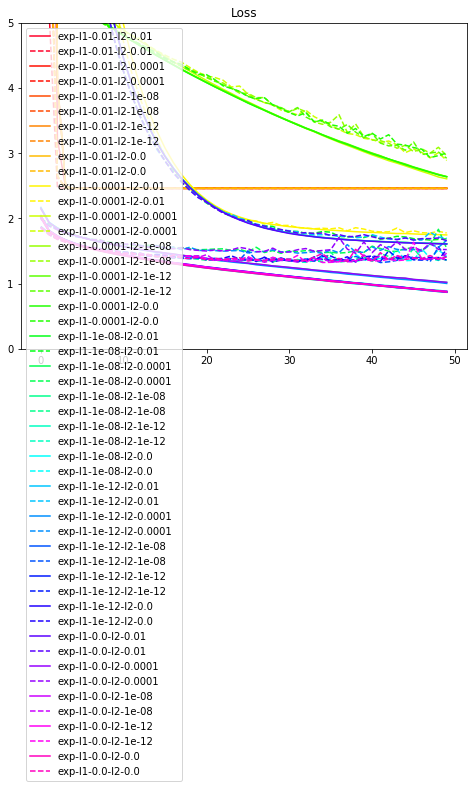

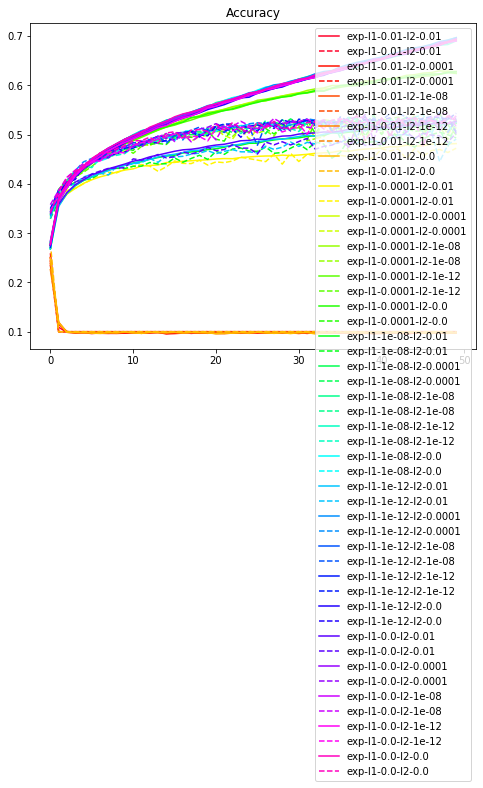

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

import matplotlib.cm as mplcm
import matplotlib.colors as colors
NUM_COLORS = 25

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-accuracy'])),results[cond]['train-accuracy'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-accuracy'])),results[cond]['valid-accuracy'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()